# Generating a novel SARS-CoV-2 T-cell epitope-specific TCR CDR3 beta sequence using the fine-tuned model
- We first select a SAR-CoV-2 T-cell epitope from the dataset, may have most CDR3 beta sequences
- then select most similar epitope from the dataset
- identify different amino acids between the two epitopes
- Find the most attentive positions in the first epitope-specific TCR CDR3 beta sequence
- Masking the attentive positions in the first epitope-specific TCR CDR3 beta sequence
- Generate the second epitope-specific TCR CDR3 beta sequences using the fine-tuned model
- Compare the generated CDR3 beta sequences with the original second CDR3 beta sequences  
 

### Global configurations

In [1]:
import pandas as pd
import numpy as np
import warnings
import logging

# Display
pd.set_option('display.max.rows', 2000)
pd.set_option('display.max.columns', 2000)

# Logger
warnings.filterwarnings('ignore')
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger('gentcr')
logger.setLevel(logging.INFO)


### Selecting a SAR-CoV-2 T-cell epitope from the dataset, may have most CDR3 beta sequences

In [2]:
from collections import OrderedDict
from gentcr.data import EpitopeTargetDataset, CN
from IPython.core.display import display

epitope_ds_map = EpitopeTargetDataset.from_key('immunecode_9mer').split_by_epitope(as_dict=True)
logger.info(f'epitopes: {epitope_ds_map.keys()}, {[(epitope, len(ds)) for epitope, ds in epitope_ds_map.items()]}')
target_epitopes = list(filter(lambda k: len(epitope_ds_map[k]) > 10000, epitope_ds_map.keys()))
logger.info(f'target_epitopes: {target_epitopes}')
#

(gentcr) 2023-11-26 15:28:25 [INFO]: Loaded immunecode_9mer data from ../output/immunecode_9mer.data.csv, df.shape: (292142, 12)
(gentcr) 2023-11-26 15:28:25 [INFO]: epitopes: odict_keys(['ADAGFIKQY', 'AEIRASANL', 'AENSVAYSN', 'AEVQIDRLI', 'AFLLFLVLI', 'AFPFTIYSL', 'AIILASFSA', 'AIMTRCLAV', 'ALALLLLDR', 'ALDPLSETK', 'ALLADKFPV', 'ALNTLVKQL', 'ALNTPKDHI', 'ALRANSAVK', 'ALSKGVHFV', 'ALWEIQQVV', 'APGQTGKIA', 'AQALNTLVK', 'AQFAPSASA', 'ASAFFGMSR', 'ASANLAATK', 'ASKIITLKK', 'ATSRTLSYY', 'ATVVIGTSK', 'AVILRGHLR', 'AVLQSGFRK', 'CNDPFLGVY', 'CPDGVKHVY', 'DFLEYHDVR', 'DGVKHVYQL', 'DLFMRIFTI', 'DSGFAAYSR', 'EEHVQIHTI', 'ELIRQGTDY', 'ELYSPIFLI', 'EYVSQPFLM', 'FAYANRNRF', 'FERDISTEI', 'FEYVSQPFL', 'FFSNVTWFH', 'FIAGLIAIV', 'FIASFRLFA', 'FLAFLLFLV', 'FLGRYMSAL', 'FLLNKEMYL', 'FLLPSLATV', 'FLNGSCGSV', 'FLNRFTTTL', 'FLPFFSNVT', 'FLPRVFSAV', 'FLQSINFVR', 'FLWLLWPVT', 'FPPTSFGPL', 'FPQSAPHGV', 'FPRGQGVPI', 'FQPTNGVGY', 'FRYMNSQGL', 'FSKQLQQSM', 'FTNVYADSF', 'FVDGVPFVV', 'FVFKNIDGY', 'FYLCFLAFL', 'GAAAY

### Selecting most similar epitope with the target epitopes

In [4]:
from collections import OrderedDict
from gentcr.bioseq import needle_aaseq_pair

sim_epitope_map = OrderedDict()
for a_epitope in target_epitopes:
    max_score = 0
    for b_epitope in epitope_ds_map.keys():
        if a_epitope != b_epitope:
            score = needle_aaseq_pair(a_epitope, b_epitope)['similarity']
            if score > max_score:
                max_score = score
                sim_epitope_map[a_epitope] = (b_epitope, score)
                logger.info(f'Current similar epitope with {a_epitope}: {b_epitope}, score: {score}')
logger.info(f'sim_epitope_map: {sim_epitope_map}')

(gentcr) 2023-11-26 15:31:42 [INFO]: Current similar epitope with AFLLFLVLI: ADAGFIKQY, score: 0.062
(gentcr) 2023-11-26 15:31:42 [INFO]: Current similar epitope with AFLLFLVLI: AEIRASANL, score: 0.133
(gentcr) 2023-11-26 15:31:42 [INFO]: Current similar epitope with AFLLFLVLI: AENSVAYSN, score: 0.14300000000000002
(gentcr) 2023-11-26 15:31:42 [INFO]: Current similar epitope with AFLLFLVLI: AEVQIDRLI, score: 0.444
(gentcr) 2023-11-26 15:31:42 [INFO]: Current similar epitope with AFLLFLVLI: ALALLLLDR, score: 0.455
(gentcr) 2023-11-26 15:31:43 [INFO]: Current similar epitope with AFLLFLVLI: FIAGLIAIV, score: 0.5
(gentcr) 2023-11-26 15:31:43 [INFO]: Current similar epitope with AFLLFLVLI: FLAFLLFLV, score: 0.636
(gentcr) 2023-11-26 15:31:47 [INFO]: Current similar epitope with AFLLFLVLI: LWLLWPVTL, score: 0.667
(gentcr) 2023-11-26 15:31:52 [INFO]: Current similar epitope with FLAFLLFLV: ADAGFIKQY, score: 0.059000000000000004
(gentcr) 2023-11-26 15:31:52 [INFO]: Current similar epitope wit

- We select two epitope pairs with the highest similarity scores, 0.778 with no gaps
- (LLFLVLIML, LDYIINLII) and (FLAFLLFLV, FIAGLIAIV)

In [6]:
sim_epitope_map = OrderedDict(filter(lambda x: x[1][1] > 0.7 and x[0] not in ['YLCFLAFLL', 'FYLCFLAFL'], sim_epitope_map.items()))
print(sim_epitope_map)
for epitope, (sim_epitope, score) in sim_epitope_map.items():
    print(f'{epitope} vs {sim_epitope}, score: {score}')
    print(needle_aaseq_pair(epitope, sim_epitope)['output'])

OrderedDict([('FLAFLLFLV', ('FIAGLIAIV', 0.778)), ('LLFLVLIML', ('LDYIINLII', 0.778))])
FLAFLLFLV vs FIAGLIAIV, score: 0.778
########################################
# Program: needle
# Rundate: Sat 25 Nov 2023 14:54:33
# Commandline: needle
#    -asequence /tmp/tmpwtdz_26p
#    -bsequence /tmp/tmpdnsrlnq0
#    -sprotein1
#    -sprotein2
#    -gapopen 10
#    -gapextend 0.5
#    -outfile stdout
# Align_format: srspair
# Report_file: stdout
########################################

#=======================================
#
# Aligned_sequences: 2
# 1: 1
# 2: 2
# Matrix: EBLOSUM62
# Gap_penalty: 10.0
# Extend_penalty: 0.5
#
# Length: 9
# Identity:       4/9 (44.4%)
# Similarity:     7/9 (77.8%)
# Gaps:           0/9 ( 0.0%)
# Score: 19.0
# 
#
#=======================================

1                  1 FLAFLLFLV      9
                     |:|.|:.:|
2                  1 FIAGLIAIV      9


#---------------------------------------
#---------------------------------------

LLFLVLIML vs LD

- Finally, we select (FLAFLLFLV, FIAGLIAIV) as the target epitope pair with 4 identical amino acids and 3 similar amino acids
- The similar aa positions are 1, 5, 7

In [6]:
import numpy as np

source_epitope = 'FIAGLIAIV'
target_epitope = 'FLAFLLFLV'
epitope_positions = np.array([1, 5, 7])
source_ds = epitope_ds_map[source_epitope]
display(source_ds.summary())
target_ds = epitope_ds_map[target_epitope]
display(target_ds.summary())
np.intersect1d(source_ds.df.cdr3b_seq.values, target_ds.df.cdr3b_seq.values)

,source,epitope_species,epitope_gene,epitope_seq,cdr3_beta,positive,negative
0,ImmuneCODE_002.1,SARS-CoV-2,surface glycoprotein,FIAGLIAIV,323,323,0


,source,epitope_species,epitope_gene,epitope_seq,cdr3_beta,positive,negative
0,ImmuneCODE_002.1,SARS-CoV-2,ORF7b,FLAFLLFLV,16643,16643,0


array(['CASSEWGDQPQHF', 'CASSLDGSSYNEQFF', 'CATGLSTDTQYF',
       'CSARDGVNTEAFF'], dtype=object)

### Find the most attentive positions at CDR3$\\beta$ sequences
 - For source dataset, we find the most attentive positions at CDR3$\\beta$ sequences to the target AA positions at the source epitope

#### Select target CDR3$\\beta$ sequences by lengths

(gentcr) 2023-11-26 15:53:11 [INFO]: For source_ds: immunecode_9mer.FIAGLIAIV, target_cdr3b_index_map: OrderedDict([(13, array([  3,   4,   9,  12,  18,  22,  23,  25,  26,  28,  34,  38,  43,
        53,  54,  56,  59,  60,  63,  68,  72,  76,  80,  84,  87,  90,
        94,  95,  96, 109, 110, 113, 123, 127, 131, 132, 145, 157, 169,
       179, 186, 189, 193, 197, 198, 200, 201, 202, 203, 205, 206, 210,
       211, 212, 216, 228, 236, 238, 241, 243, 251, 261, 263, 266, 267,
       268, 272, 280, 281, 284, 289, 291, 296, 297, 299, 300, 302, 303,
       304, 308, 309, 313, 314, 320])), (14, array([  0,   1,  10,  36,  41,  44,  50,  51,  65,  66,  67,  74,  78,
        79,  98,  99, 103, 115, 116, 117, 119, 133, 140, 142, 146, 151,
       152, 154, 159, 164, 167, 170, 172, 173, 181, 182, 183, 184, 190,
       192, 196, 207, 214, 219, 220, 225, 235, 249, 253, 256, 257, 265,
       270, 271, 275, 276, 278, 283, 288, 292, 295, 301, 312, 315, 317,
       318])), (15, array([  5,   6,   8, 

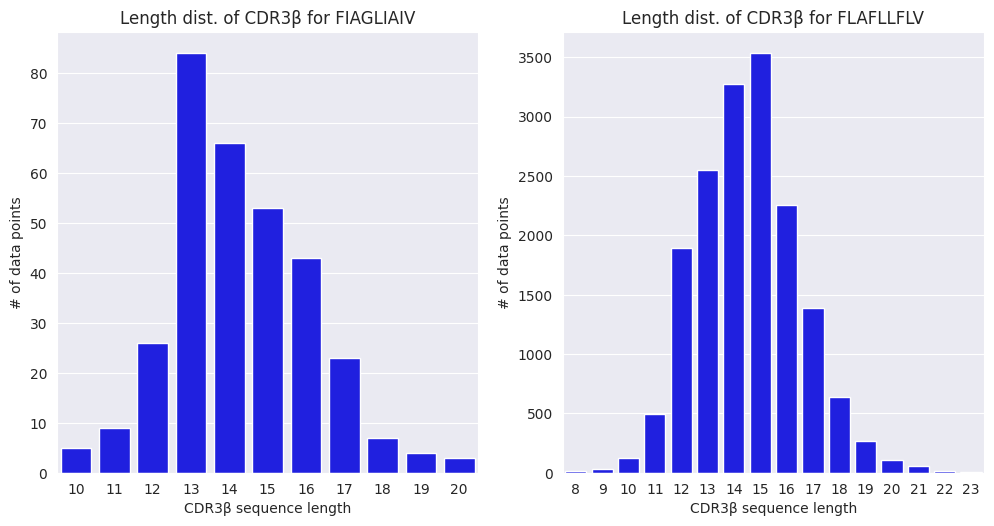

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def get_len_cdr3b_index_map(df, max_ratio=0.9, ax=None):
    cdr3b = df[CN.cdr3b_seq].values
    lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), cdr3b)).items()))
    lens = np.array(lens)
    cnts = np.array(cnts)
    if ax:
        sns.barplot(x=lens, y=cnts, color='blue', ax=ax)
        ax.set_title(f'Length dist. of CDR3β for {df.epitope_seq.values[0]}')
        ax.set_xlabel('CDR3β sequence length')
        ax.set_ylabel('# of data points')

    # Select target indices by cdr3b sequence lengths
    target_index_map = OrderedDict()
    order = np.argsort(cnts)[::-1]
    cum_cnt = 0
    for cur_len, cur_cnt in zip(lens[order], cnts[order]):
        cum_cnt += cur_cnt
        cum_ratio = cum_cnt/cdr3b.shape[0]
        logger.debug(f'cum_ratio: {cum_cnt}/{cdr3b.shape[0]}={cum_ratio}')
        if cum_ratio < max_ratio:
            target_indices = np.where(df.cdr3b_len == cur_len)[0]
            logger.debug(f'target_indices for {cur_len}: {target_indices}({target_indices.shape[0]})')
            target_index_map[cur_len] = target_indices
    return target_index_map

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(5)
plt.tight_layout(w_pad=3)

source_len_cdr3b_index_map = get_len_cdr3b_index_map(df=source_ds.df, max_ratio=0.8, ax=axes[0])
logger.info(f'For source_ds: {source_ds.name}, target_cdr3b_index_map: {source_len_cdr3b_index_map}')
target_len_cdr3b_index_map = get_len_cdr3b_index_map(df=target_ds.df, max_ratio=0.8, ax=axes[1])
logger.info(f'For target_ds: {target_ds.name}, target_cdr3b_index_map: {target_len_cdr3b_index_map}')

#### Investigate the source and target CDR3$\\beta$ sequences
- We select most frequent CDR3$\\beta$ sequences with length 13 in the source and target dataset

In [17]:
from gentcr.bioseq import write_fa

source_cdr3bs = source_ds.df[source_ds.df.cdr3b_len == 13].cdr3b_seq.values
target_cdr3bs = target_ds.df[target_ds.df.cdr3b_len == 13].cdr3b_seq.values

write_fa(f'../output/exp3/{source_epitope}_cdr3b.fa', source_cdr3bs)
write_fa(f'../output/exp3/{target_epitope}_cdr3b.fa', target_cdr3bs)

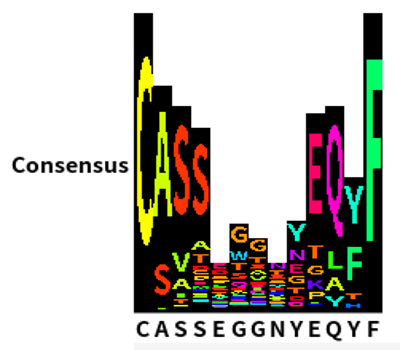

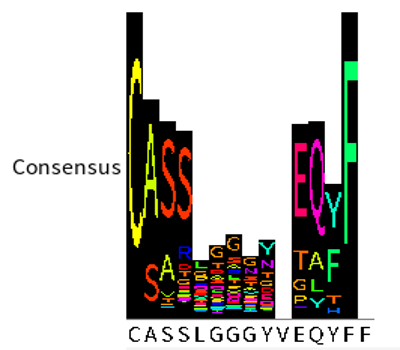

In [34]:
from PIL import Image
from IPython.display import display

display(Image.open(f'../output/exp3/{source_epitope}_cdr3b_seqlogo.png').resize((400, 350)), 
        Image.open(f'../output/exp3/{target_epitope}_cdr3b_seqlogo.png').resize((400, 350)))
# plt.imshow('../output/exp3/FIAGLIAIV_cdr3b_seqlogo.png')

- We find that the source and target CDR3$\\beta$ sequences have similar amino acids
- The target CDR3$\\beta$ sequences have rare amino acids, such as V at 9th position and F at last position
- There are critical substitutions at 5th and 8th positions, E>L and N>Y
- BLOSUM62 scores for the substitutions are -3 and -2, respectively and the scores are not very low

#### Load the fine-tuned model

In [43]:
from transformers import AutoTokenizer
from peft import AutoPeftModel

def load_model(model_path):
    model = AutoPeftModel.from_pretrained(model_path, device_map='auto', output_attentions=True).eval()
    # model = model.merge_and_unload()
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

model, tokenizer = load_model('../output/exp3/mlm_finetune')

(urllib3.connectionpool) 2023-11-27 11:00:32 [DEBUG]: https://huggingface.co:443 "HEAD /facebook/esm2_t33_650M_UR50D/resolve/main/config.json HTTP/1.1" 200 0
(urllib3.connectionpool) 2023-11-27 11:00:33 [DEBUG]: https://huggingface.co:443 "HEAD /facebook/esm2_t33_650M_UR50D/resolve/main/config.json HTTP/1.1" 200 0


####  Predicting the source dataset

In [52]:
from itertools import repeat
import torch
from gentcr.data import EpitopeTargetMaskedLMCollator

def predict(model, inputs, tokenizer=None):
    max_epitope_len = max([len(x[0]) for x in inputs])
    max_target_len = max([len(x[1]) for x in inputs])
    
    collator = EpitopeTargetMaskedLMCollator(tokenizer=tokenizer, 
                                             epitope_seq_mutator=None, 
                                             target_seq_mutator=None,
                                             max_epitope_len=max_epitope_len,
                                             max_target_len=max_target_len,
                                             seq_format='{epitope_seq}{target_seq}')
    inputs = collator(inputs)
    outputs = model(**inputs)
    return outputs

inputs = list(zip(repeat(source_epitope), source_cdr3bs, repeat(1)))
outputs = predict(model, inputs, tokenizer=tokenizer)
max_len = outputs.logits.shape[1]
logger.info(f'outputs.logits.shape: {outputs.logits.shape}, max_len: {max_len}')
tokenizer.batch_decode(torch.argmax(outputs.logits, dim=-1))

(gentcr) 2023-11-27 14:37:44 [INFO]: outputs.logits.shape: torch.Size([84, 24, 33]), max_len: 24


['<cls> F I A G L I A I V C S A R D G V N T E A F F <eos>',
 '<cls> F I A G L I A I V C S V D E G G T G E L F F <eos>',
 '<cls> F I A G L I A I V C A S S Q E G A G E Q F F <eos>',
 '<cls> F I A G L I A I V C A S S D W A S Y E Q Y F <eos>',
 '<cls> F I A G L I A I V C A S S A G Q Y Y G Y T F <eos>',
 '<cls> F I A G L I A I V C A S R G G R G Y E Q Y F <eos>',
 '<cls> F I A G L I A I V C A S S L G G R E E Q Y F <eos>',
 '<cls> F I A G L I A I V C A S S L G V R E T Q Y F <eos>',
 '<cls> F I A G L I A I V C A S G E L N T G E L F F <eos>',
 '<cls> F I A G L I A I V C A S A T G G T D T Q Y F <eos>',
 '<cls> F I A G L I A I V C A S S L G V R N E A F F <eos>',
 '<cls> F I A G L I A I V C A S S L T G T G E L F F <eos>',
 '<cls> F I A G L I A I V C A S S L D T G Y G Y T F <eos>',
 '<cls> F I A G L I A I V C A S S E G V D N E Q F F <eos>',
 '<cls> F N A G L I A I V C S V Y G G L T G E L F F <eos>',
 '<cls> F I A G L I A I V C A T T S G R N N E Q F F <eos>',
 '<cls> F I A G L I A I V C S V A R G D 

In [60]:
model.esm.encoder.layer[0].attention.self.value
from captum.attr import LayerActivation

Linear(
  in_features=1280, out_features=1280, bias=True
  (lora_dropout): ModuleDict(
    (default): Dropout(p=0.05, inplace=False)
  )
  (lora_A): ModuleDict(
    (default): Linear(in_features=1280, out_features=16, bias=False)
  )
  (lora_B): ModuleDict(
    (default): Linear(in_features=16, out_features=1280, bias=False)
  )
  (lora_embedding_A): ParameterDict()
  (lora_embedding_B): ParameterDict()
)

##### Get attentions for the source dataset

In [41]:
from torch.utils.data import DataLoader
from gentcr.data import EpitopeTargetMaskedLMCollator
from gentcr.common import TorchUtils
import torch

def get_attentions(ds, target_model, tokenizer, target_layers=None):
    collator = EpitopeTargetMaskedLMCollator(tokenizer=tokenizer, 
                                             epitope_seq_mutator=None, 
                                             target_seq_mutator=None,
                                             max_epitope_len=ds.max_epitope_len,
                                             max_target_len=ds.max_target_len,
                                             seq_format='{epitope_seq}{target_seq}')
    data_loader = DataLoader(ds, batch_size=len(ds), shuffle=False, collate_fn=collator)
    batch = next(iter(data_loader))
    output = target_model(**batch)
    attns = TorchUtils.to_numpy(torch.stack(output.attentions, dim=0), use_cuda=True)
    return attns[target_layers] if target_layers is not None else attns

target_layers = list(range(10))
attentions = get_attentions(source_ds, model, tokenizer, target_layers=target_layers)
# attentions.shape == (n_layers, n_samples, n_heads, max_len, max_len)
logger.info(f'target_layers: {target_layers}, attentions.shape: {attentions.shape}')
mean_attentions = attentions[5:].mean(axis=(0, 2))[:, 1:-1, 1:-1]
logger.info(f'mean_attentions.shape: {mean_attentions.shape}, max_aaseq_len: {source_ds.max_epitope_len + source_ds.max_target_len}')
mean_attentions.mean(axis=0)

(gentcr) 2023-11-27 10:57:14 [INFO]: target_layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], attentions.shape: (10, 323, 20, 31, 31)
(gentcr) 2023-11-27 10:57:14 [INFO]: mean_attentions.shape: (323, 29, 29), max_aaseq_len: 29


array([[0.05555423, 0.035889  , 0.0271594 , 0.03068022, 0.02921492,
        0.02820531, 0.02970832, 0.03570143, 0.03255376, 0.02781898,
        0.02781454, 0.03076486, 0.03219506, 0.03189187, 0.02762522,
        0.02494039, 0.0247387 , 0.02631613, 0.02858214, 0.03167791,
        0.03053299, 0.03725449, 0.05994442, 0.04627511, 0.0348507 ,
        0.02447441, 0.0120097 , 0.00382919, 0.0020086 ],
       [0.04505716, 0.04197615, 0.03087016, 0.03230114, 0.02685855,
        0.02767305, 0.02920212, 0.03524238, 0.03315325, 0.0307639 ,
        0.02901148, 0.02831274, 0.02960279, 0.03132169, 0.03125266,
        0.02858548, 0.02703283, 0.02715669, 0.02894126, 0.03327577,
        0.03607983, 0.04127315, 0.05972129, 0.04483968, 0.03423346,
        0.02414282, 0.01206432, 0.00386955, 0.00209341],
       [0.04012209, 0.03628912, 0.03718221, 0.03213658, 0.02821031,
        0.02561545, 0.03229278, 0.03113691, 0.03281791, 0.03441805,
        0.03453206, 0.03119678, 0.03092793, 0.03179513, 0.03199414,
  

(gentcr) 2023-11-27 10:57:18 [INFO]: Attention weights for 13: [0.03313689 0.02963233 0.02807186 0.03062069 0.02868393 0.02584103
 0.02774539 0.03220725 0.02994484 0.0309475  0.03209653 0.03086375
 0.03051156 0.03112087 0.03133782 0.03099184 0.02961929 0.03040113
 0.03231921 0.03221947 0.03251035 0.04646777 0.19455881]
(gentcr) 2023-11-27 10:57:18 [INFO]: Attention weights for 14: [0.03232064 0.0286994  0.02726226 0.02983378 0.02808649 0.02481948
 0.02597248 0.03084129 0.0296703  0.0298498  0.03148634 0.03053708
 0.03006317 0.02948692 0.02970219 0.03026527 0.02981665 0.02850598
 0.03013711 0.03100777 0.03127721 0.0316726  0.04464674 0.18860504]
(gentcr) 2023-11-27 10:57:18 [INFO]: Attention weights for 15: [0.0314356  0.02763806 0.02603194 0.02854212 0.02755588 0.02451933
 0.0251279  0.02967088 0.02852274 0.02982    0.03060302 0.03016091
 0.03010032 0.02893562 0.02900425 0.03025022 0.0295676  0.02814991
 0.02737899 0.02950342 0.03108597 0.03066854 0.03097315 0.04247184
 0.17889974]
(ge

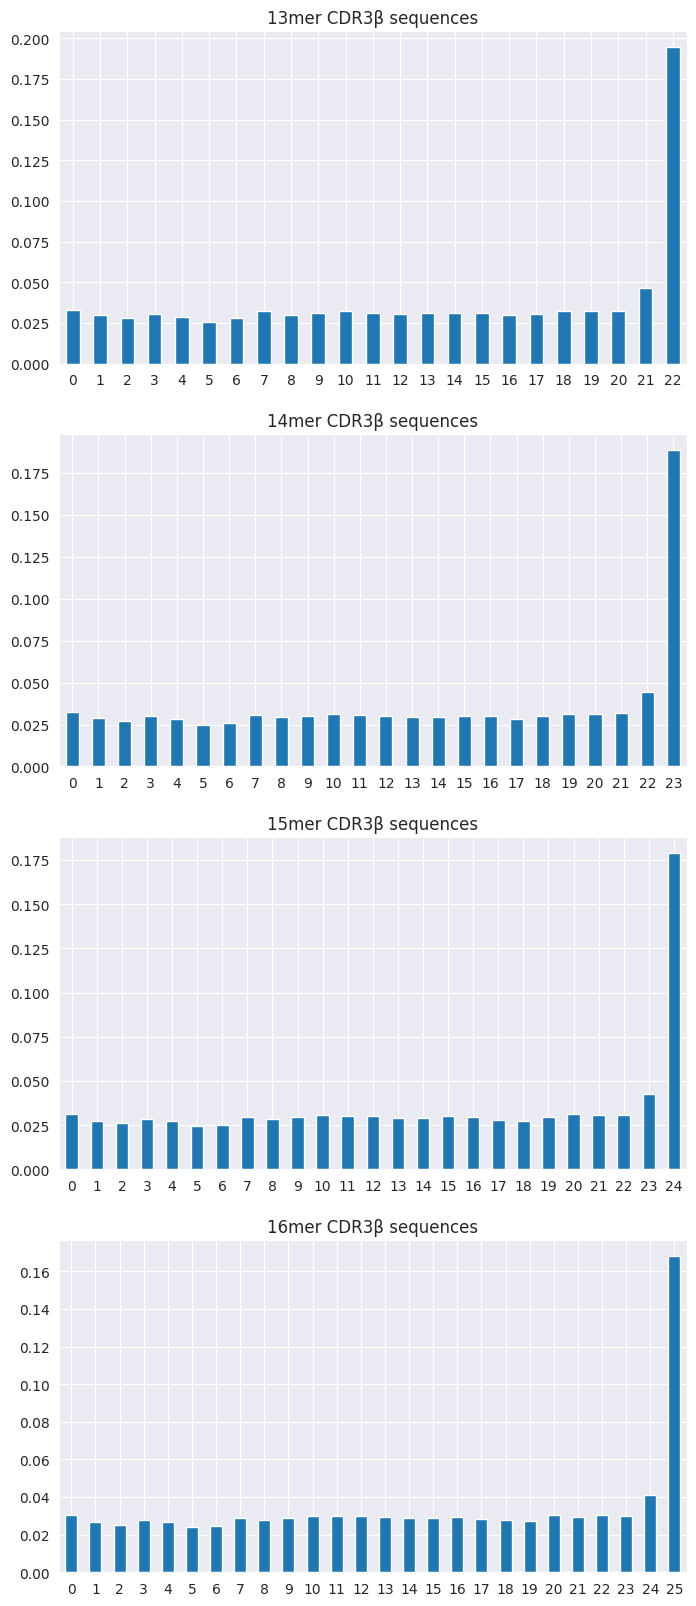

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

def draw_attns(attns, epitope, target_cdr3b_indices, cdr3b_len=None, ax=None):
    epitope_len = len(epitope)
    sent_len = epitope_len + cdr3b_len
    target_attns = np.mean(attns[target_cdr3b_indices], axis=(0, 1))[:sent_len+1]
    logger.info('Attention weights for %s: %s' % (cdr3b_len, target_attns))

    pd.Series(target_attns).plot(kind='bar', ax=ax, rot=0)
    ax.set_title('%smer CDR3β sequences' % cdr3b_len)
    # ticks = list(epitope) + list(range(1, cdr3b_len + 1))
    # mark_ratio = 0.1
    # mark_pos = []
    # for rank, pos in enumerate(np.argsort(target_attns[:epitope_len])[::-1]):
    #     if rank < (epitope_len*mark_ratio):
    #         ticks[pos] = '%s\n•' % (ticks[pos])
    #         mark_pos.append(pos)
    # for rank, pos in enumerate(np.argsort(target_attns[epitope_len:])[::-1]):
    #     if rank < (cdr3b_len*mark_ratio):
    #         ticks[epitope_len+pos] = '%s\n•' % (ticks[epitope_len+pos])
    #         mark_pos.append(epitope_len+pos)
    # ax.set_xticklabels(ticks)
    # for i, tick in enumerate(ax.get_xticklabels()):
    #     if i < epitope_len:
    #         tick.set_color('green')
    #     else:
    #         tick.set_color('black')
    #     if i in mark_pos:
    #         tick.set_color('darkred')

fig, axes = plt.subplots(nrows=len(source_len_cdr3b_index_map), ncols=1)
fig.set_figwidth(7)
fig.set_figheight(4*len(source_len_cdr3b_index_map))
plt.tight_layout(h_pad=3, w_pad=3)

for i, (cur_len, cur_indices) in enumerate(source_len_cdr3b_index_map.items()):
    draw_attns(attns=mean_attentions,
               epitope=source_epitope,
               target_cdr3b_indices=cur_indices, 
               cdr3b_len=cur_len, 
               ax=axes[i] if len(source_len_cdr3b_index_map) > 1 else axes)
